In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
df=pd.read_csv('RSCCASN.csv',index_col='DATE',parse_dates=True)

In [4]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


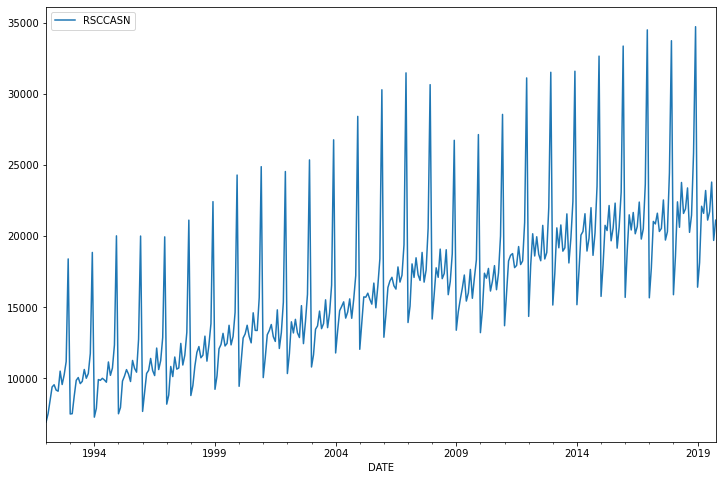

In [5]:
df.plot(figsize=(12,8))

# Train Test Split

In [6]:
len(df)

334

In [7]:
len(df)- 18

316

In [8]:
test_size = 18

In [9]:
test_ind = len(df)- test_size

In [10]:
test_ind

316

In [11]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [12]:
train

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585


In [13]:
test

,RSCCASN
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260
2018-10-01,21473
2018-11-01,25831
2018-12-01,34706
2019-01-01,16410


# Scale the Data

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
scaler = MinMaxScaler()

In [16]:
scaler.fit(train)

MinMaxScaler()

In [17]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# Time Series Generator

In [18]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [19]:
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [20]:
X,y = generator[0]

In [21]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.         0.02127505 0.05580163 0.08942056 0.09512053 0.08146965
 0.07860151 0.12979233 0.09566512 0.1203892  0.15426227 0.41595266]
Predict this y: 
 [[0.02047633]]


# Creating a Model

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [23]:
n_features = 1

In [24]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


# Early Stopping and creating a Validation Generator

In [26]:
from tensorflow.keras.callbacks import EarlyStopping

In [27]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [28]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [29]:
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 304 steps, validate for 6 steps
Epoch 1/20
304/304 [==============================] - 6s 19ms/step - loss: 0.0287 - val_loss: 0.0027
Epoch 2/20
304/304 [==============================] - 2s 8ms/step - loss: 0.0192 - val_loss: 0.0079
Epoch 3/20
304/304 [==============================] - 2s 7ms/step - loss: 0.0131 - val_loss: 0.0016
Epoch 4/20
304/304 [==============================] - 2s 7ms/step - loss: 0.0086 - val_loss: 0.0036
Epoch 5/20
304/304 [==============================] - 2s 7ms/step - loss: 0.0033 - val_loss: 9.0912e-04
Epoch 6/20
304/304 [==============================] - 2s 7ms/step - loss: 0.0020 - val_loss: 4.9573e-04
Epoch 7/20
304/304 [==============================] - 2s 7ms/step - loss: 0.0018 - val_loss: 6.8920e-04
Epoch 8/20
304/304 [==============================] - 2s 8ms/step - loss: 0.0024 - val_loss: 8.1674e-04


In [30]:
losses = pd.DataFrame(model.history.history)

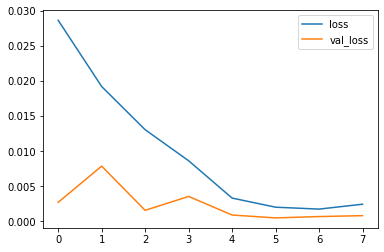

In [31]:
losses.plot()

# Evaluate on Test Data


In [32]:
first_eval_batch = scaled_train[-length:]

In [2]:
#first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

In [1]:
#model.predict(first_eval_batch)

In [35]:
scaled_test[0]

array([0.61087714])

In [36]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

# Inverse Transformations and Compare

In [37]:
true_predictions = scaler.inverse_transform(test_predictions)

In [38]:
true_predictions = scaler.inverse_transform(test_predictions)

In [39]:
test

,RSCCASN
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260
2018-10-01,21473
2018-11-01,25831
2018-12-01,34706
2019-01-01,16410


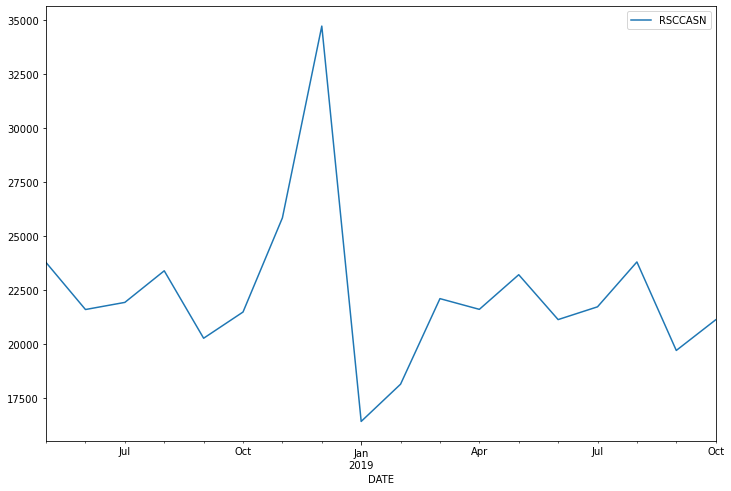

In [40]:
test.plot(figsize=(12,8))

# Retraining and Forecasting

In [41]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [42]:
length = 12 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [43]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# fit model
model.fit_generator(generator,epochs=8)

  ...
    to  
  ['...']
Train for 322 steps
Epoch 1/8
322/322 [==============================] - 4s 12ms/step - loss: 0.0248
Epoch 2/8
322/322 [==============================] - 2s 7ms/step - loss: 0.0174
Epoch 3/8
322/322 [==============================] - 2s 7ms/step - loss: 0.0089
Epoch 4/8
322/322 [==============================] - 2s 7ms/step - loss: 0.0036
Epoch 5/8
322/322 [==============================] - 2s 7ms/step - loss: 0.0044
Epoch 6/8
322/322 [==============================] - 2s 7ms/step - loss: 0.0018
Epoch 7/8
322/322 [==============================] - 2s 7ms/step - loss: 0.0035
Epoch 8/8
322/322 [==============================] - 2s 7ms/step - loss: 0.0013


In [44]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [45]:
forecast = scaler.inverse_transform(forecast)

# Creating new timestamp index with pandas

In [46]:
forecast_index = pd.date_range(start='2019-11-01',periods=periods,freq='MS')

In [47]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [48]:
forecast_df

,Forecast
2019-11-01,26188.379680
2019-12-01,36295.740101
2020-01-01,17269.940375
2020-02-01,19033.695745
2020-03-01,22570.559537
2020-04-01,22155.866536
2020-05-01,23633.543627
2020-06-01,21778.690814
2020-07-01,22337.811875
2020-08-01,24233.910382


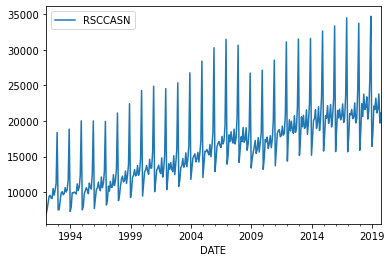

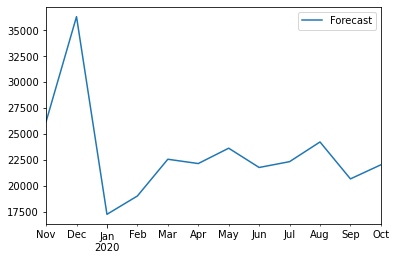

In [49]:
df.plot()
forecast_df.plot()

# Joining pandas plots

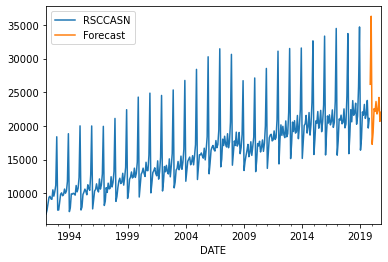

In [50]:
ax = df.plot()
forecast_df.plot(ax=ax)

(576.0, 611.0)

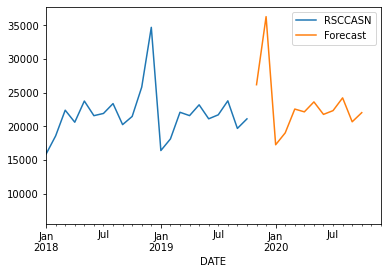

In [51]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')